# Audio-based Depression Detection Model

In [1]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.audio_rnn import AudioRNN
from preprocessing.loader_audio import AudioLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_audio_rnn import AudioRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.02  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3],
    'learning_rate': [0.001, 0.0001],
}

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Preparation

In [2]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the audio data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    audio_loader = AudioLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_audio = audio_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_audio, df_result


# Load the data
df_audio, df_result = load_data()

# Display data 
print("Audio Features:")
display(df_audio.head())
print("\nReslutls:")
display(df_result.head())

Audio Features:


AUDIO_AMPLITUDE  FORMANT_F1  FORMANT_F2  FORMANT_F3  \
ID  TIMESTAMP                                                              
386 0 days 00:00:00        -0.000048  616.206600  1571.05937  2554.39041   
    0 days 00:00:10        -0.000021  719.887378  1726.74306  2604.00720   
    0 days 00:00:20        -0.000019  612.623780  1657.20697  2569.88200   
    0 days 00:00:30        -0.000018  536.712790  1657.41013  2599.18730   
    0 days 00:00:40        -0.000022  470.127492  1633.53475  2605.33350   

                     FORMANT_F4  FORMANT_F5  COVAREP_F0  COVAREP_VUV  \
ID  TIMESTAMP                                                          
386 0 days 00:00:00   3445.9205   4352.0802  245.137862     0.135864   
    0 days 00:00:10   3483.4309   4403.4083  250.681000     0.045000   
    0 days 00:00:20   3456.0944   4344.0295  248.715000     0.447000   
    0 days 00:00:30   3511.1177   4367.7521  234.705000     0.432000   
    0 days 00:00:40   3511.1365   4338.1031  220.724000     0.512000   

                     COVAREP_NAQ  COVAREP_QOQ  ...  COVAREP_HMPDD_3  \
ID  TIMESTAMP                                  ...                    
386 0 days 00:00:00     0.056730     0.149584  ...        -1.062799   
    0 days 00:00:10     0.042286     0.104357  ...        -1.052954   
    0 days 00:00:20     0.057813     0.177422  ...        -1.153109   
    0 days 00:00:30     0.057716     0.172310  ...        -1.110354   
    0 days 00:00:40     0.062179     0.199344  ...        -1.129166   

                     COVAREP_HMPDD_4  COVAREP_HMPDD_5  COVAREP_HMPDD_6  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00        -0.910910        -0.758521        -0.613507   
    0 days 00:00:10        -0.925207        -0.766942        -0.607204   
    0 days 00:00:20        -0.958462        -0.744294        -0.547146   
    0 days 00:00:30        -0.951042        -0.752529        -0.588987   
    0 days 00:00:40        -0.958056        -0.773425        -0.608138   

                     COVAREP_HMPDD_7  COVAREP_HMPDD_8  COVAREP_HMPDD_9  \
ID  TIMESTAMP                                                            
386 0 days 00:00:00        -0.478457        -0.375517        -0.274640   
    0 days 00:00:10        -0.481018        -0.377985        -0.286668   
    0 days 00:00:20        -0.379929        -0.244665        -0.128930   
    0 days 00:00:30        -0.437365        -0.304667        -0.201107   
    0 days 00:00:40        -0.461581        -0.311399        -0.188094   

                     COVAREP_HMPDD_10  COVAREP_HMPDD_11  COVAREP_HMPDD_12  
ID  TIMESTAMP                                                              
386 0 days 00:00:00         -0.181269         -0.112634         -0.051552  
    0 days 00:00:10         -0.210696         -0.138245         -0.087930  
    0 days 00:00:20         -0.052521         -0.002873          0.032831  
    0 days 00:00:30         -0.129641         -0.062379         -0.012266  
    0 days 00:00:40         -0.109726         -0.051157          0.013474  

[5 rows x 80 columns]


Reslutls:


,PHQ_Binary
ID,
386,1
391,0


## Exploratory Data Analysis

Basic statistics for audio features:
       AUDIO_AMPLITUDE  FORMANT_F1   FORMANT_F2   FORMANT_F3   FORMANT_F4  \
count       173.000000  173.000000   173.000000   173.000000   173.000000   
mean         -0.000023  600.266186  1609.055183  2544.109598  3447.162709   
std           0.000011   58.174058    48.917096    47.323767    42.927462   
min          -0.000094  379.650000  1449.308980  2329.221780  3227.772300   
25%          -0.000027  567.147970  1578.039940  2513.867100  3420.798600   
50%          -0.000023  594.918430  1607.529560  2548.410700  3445.920500   
75%          -0.000019  628.113565  1639.191450  2573.139050  3476.711000   
max           0.000049  830.118787  1782.559460  2657.385000  3543.544200   

        FORMANT_F5  COVAREP_F0  COVAREP_VUV  COVAREP_NAQ  COVAREP_QOQ  ...  \
count   173.000000  173.000000   173.000000   173.000000   173.000000  ...   
mean   4324.200332  226.605150     0.428758     0.058391     0.191678  ...   
std      48.102999   23.582975     

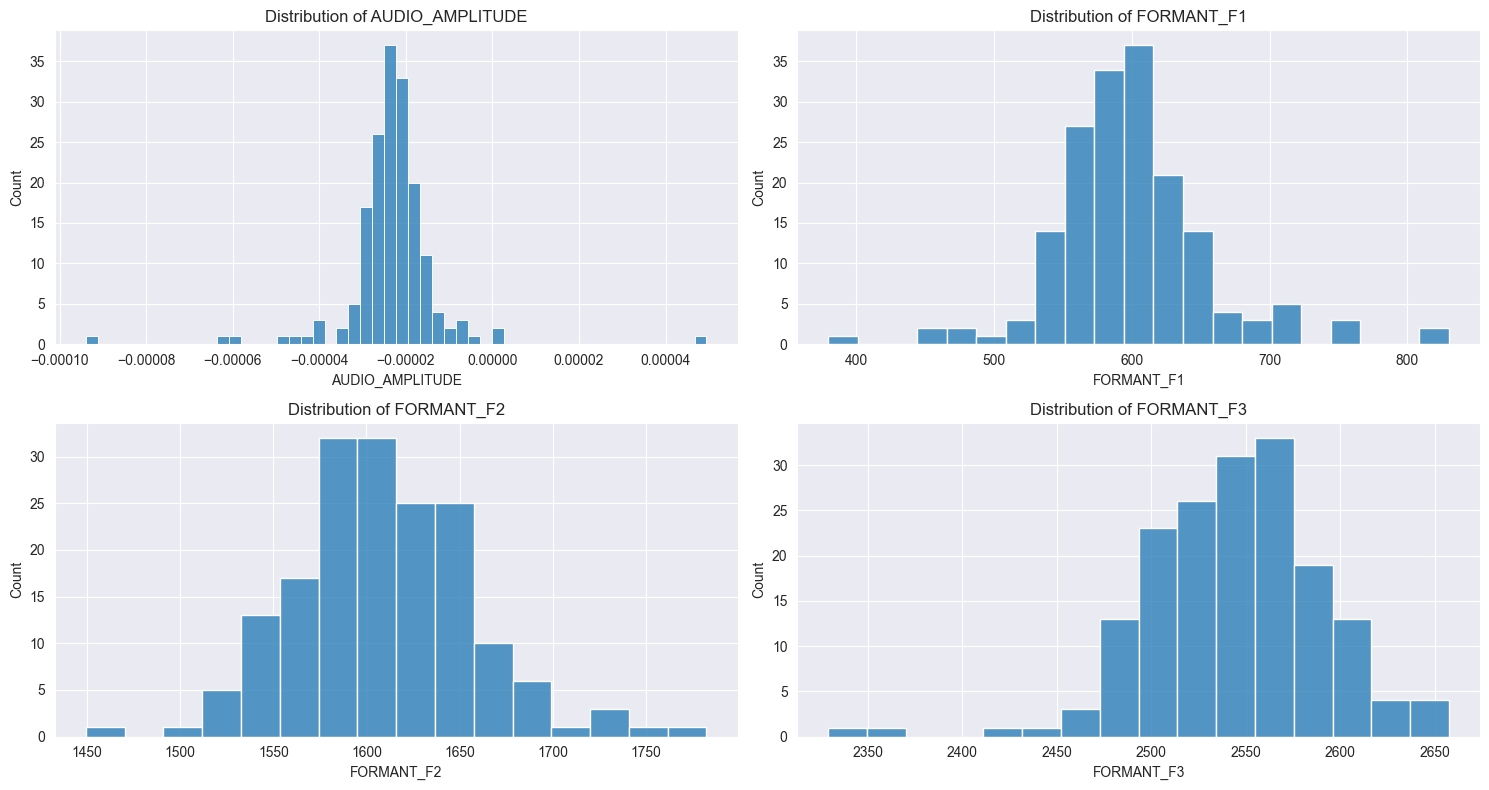

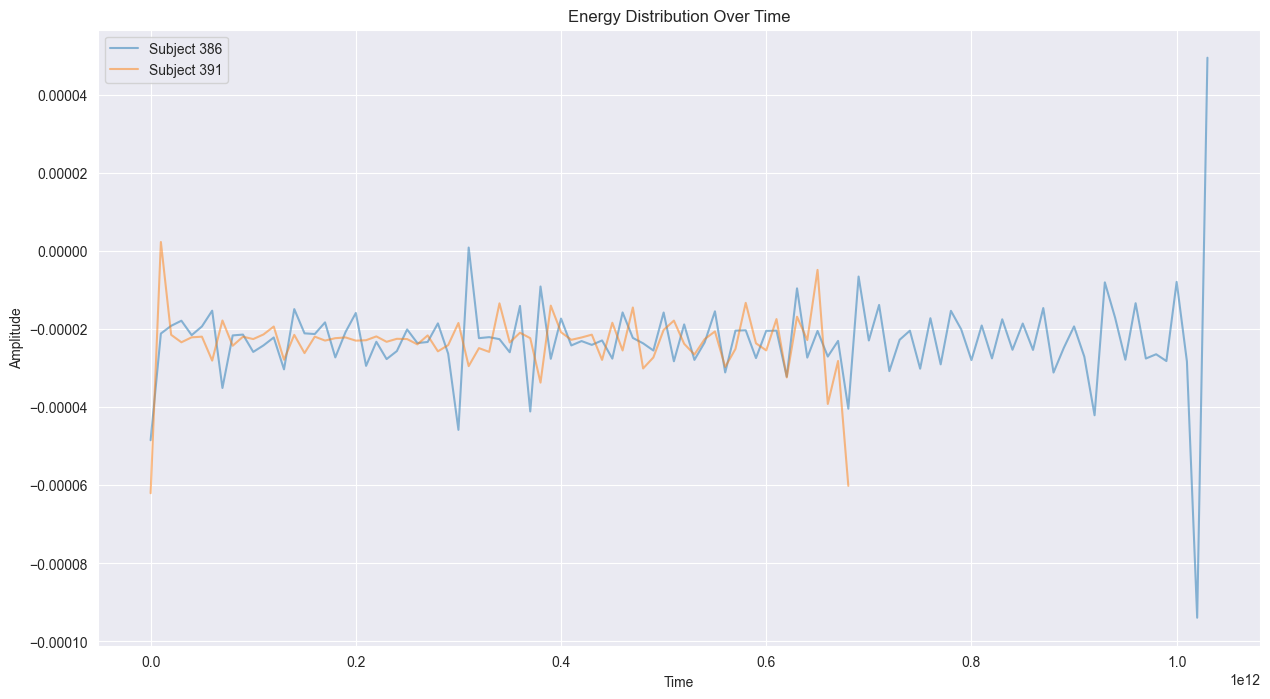

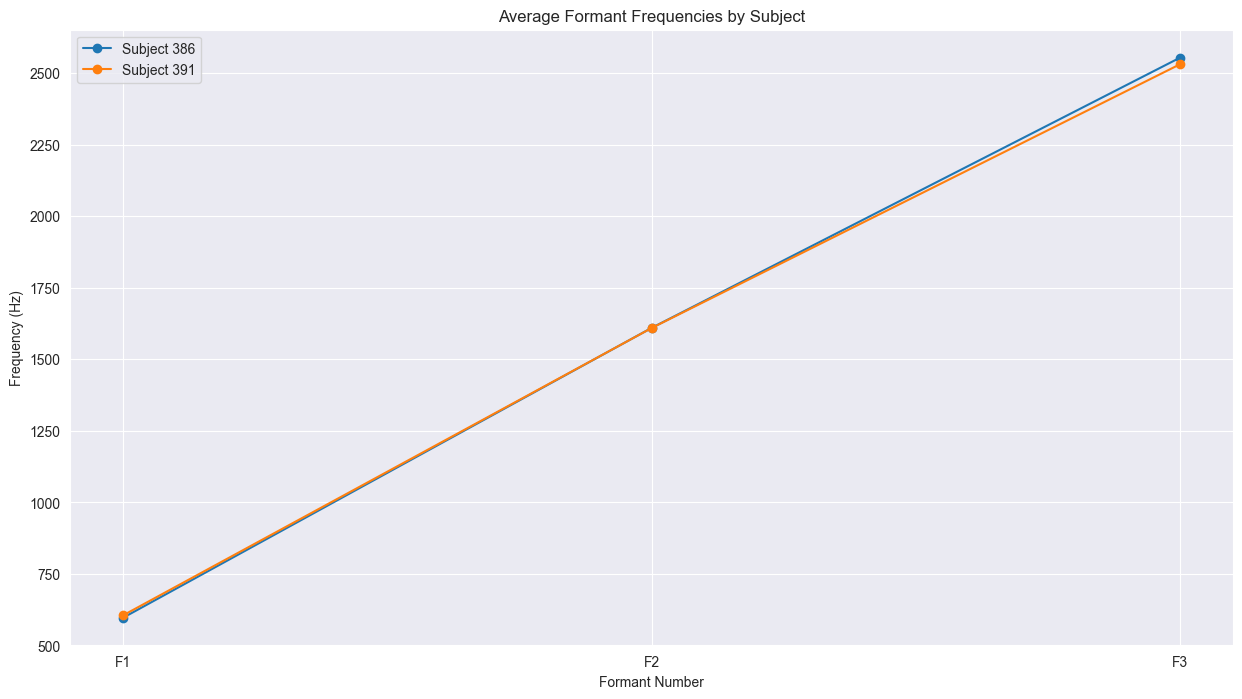

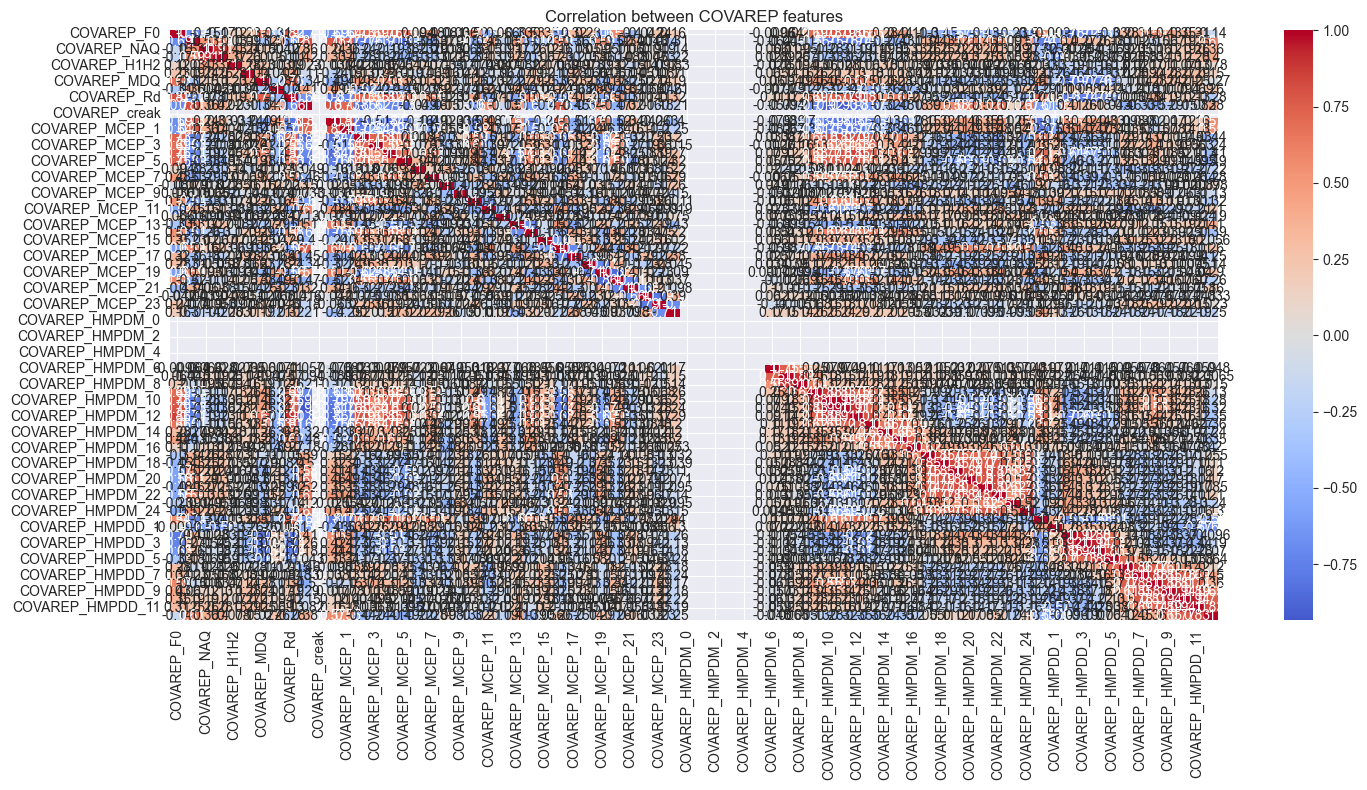

Subject 386 approximate speech activity rate: 0.0288
Subject 391 approximate speech activity rate: 0.0290


In [3]:
def plot_feature_distributions(df: pd.DataFrame, features: List[str], fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot distributions of specified features.
    # for plotting distributions of key audio features (provided as a param for flexibility)

    n_features = len(features)
    n_cols = min(2, n_features)
    n_rows = (n_features + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    axes = axes.ravel()

    for idx, feature in enumerate(features):
        sns.histplot(data=df[feature], ax=axes[idx])
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel(feature)

    plt.tight_layout()
    plt.show()


def plot_energy_distribution(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot energy distribution over time for each subject.
    plt.figure(figsize=fig_size)
    for id in df.index.get_level_values('ID').unique():
        plt.plot(df.loc[id]['AUDIO_AMPLITUDE'],
                 alpha=0.5,
                 label=f'Subject {id}')
    plt.title('Energy Distribution Over Time')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


def plot_formant_frequencies(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot average formant frequencies by subject.
    plt.figure(figsize=fig_size)
    formant_features = ['FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']

    for id in df.index.get_level_values('ID').unique():
        subject_data = df.loc[id][formant_features]
        plt.plot(subject_data.mean(), 'o-', label=f'Subject {id}')

    plt.title('Average Formant Frequencies by Subject')
    plt.xlabel('Formant Number')
    plt.ylabel('Frequency (Hz)')
    plt.xticks([0, 1, 2], ['F1', 'F2', 'F3'])
    plt.legend()
    plt.show()


# Basic statistics
print("Basic statistics for audio features:")
print(df_audio.describe())

# Plot distributions of key audio features
audio_features = ['AUDIO_AMPLITUDE', 'FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']
plot_feature_distributions(df_audio, audio_features)

# Energy distribution over time
plot_energy_distribution(df_audio)

# Formant frequencies analysis
plot_formant_frequencies(df_audio)

# COVAREP features analysis
covarep_cols = [col for col in df_audio.columns if 'COVAREP' in col]
if covarep_cols:
    plt.figure(figsize=FIGURE_SIZE)
    sns.heatmap(df_audio[covarep_cols].corr(),
                annot=True,
                cmap='coolwarm',
                center=0)
    plt.title('Correlation between COVAREP features')
    plt.tight_layout()
    plt.show()

# Speech rate analysis (using amplitude changes as proxy)
for id in df_audio.index.get_level_values('ID').unique():
    subject_data = df_audio.loc[id]['AUDIO_AMPLITUDE']
    # Calculate zero crossings as a rough measure of speech activity
    zero_crossings = np.where(np.diff(np.signbit(subject_data)))[0]
    speech_rate = len(zero_crossings) / len(subject_data)
    print(f"Subject {id} approximate speech activity rate: {speech_rate:.4f}")


## Principal Component Analysis

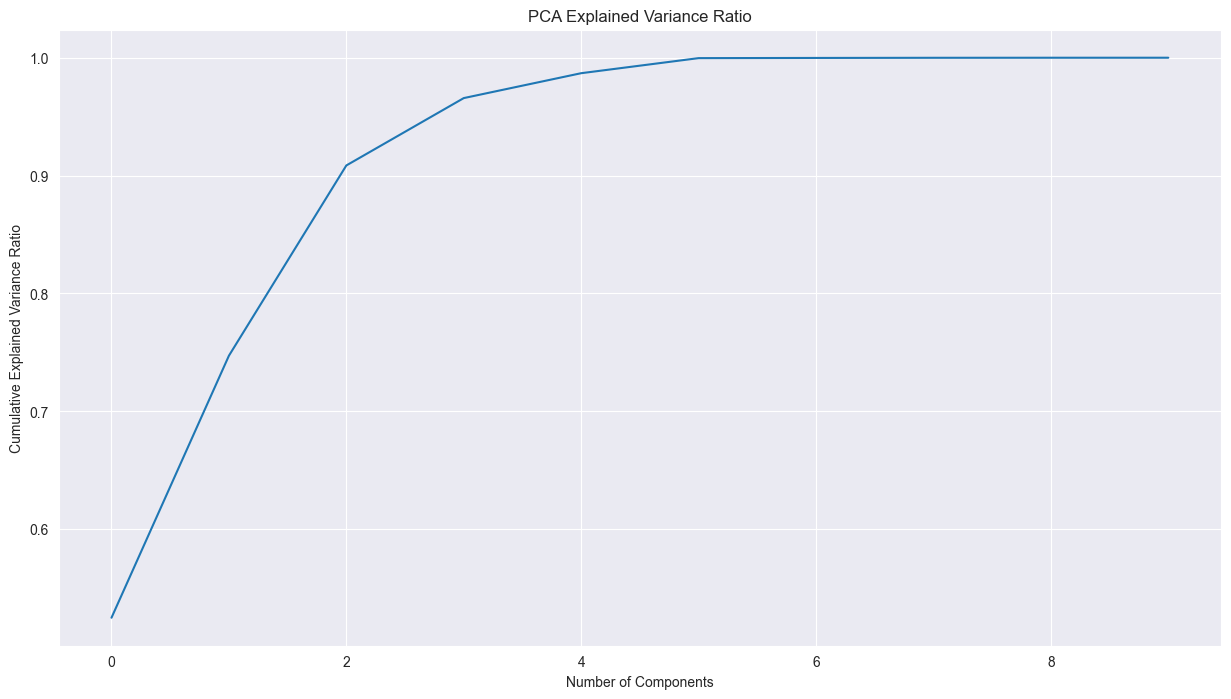

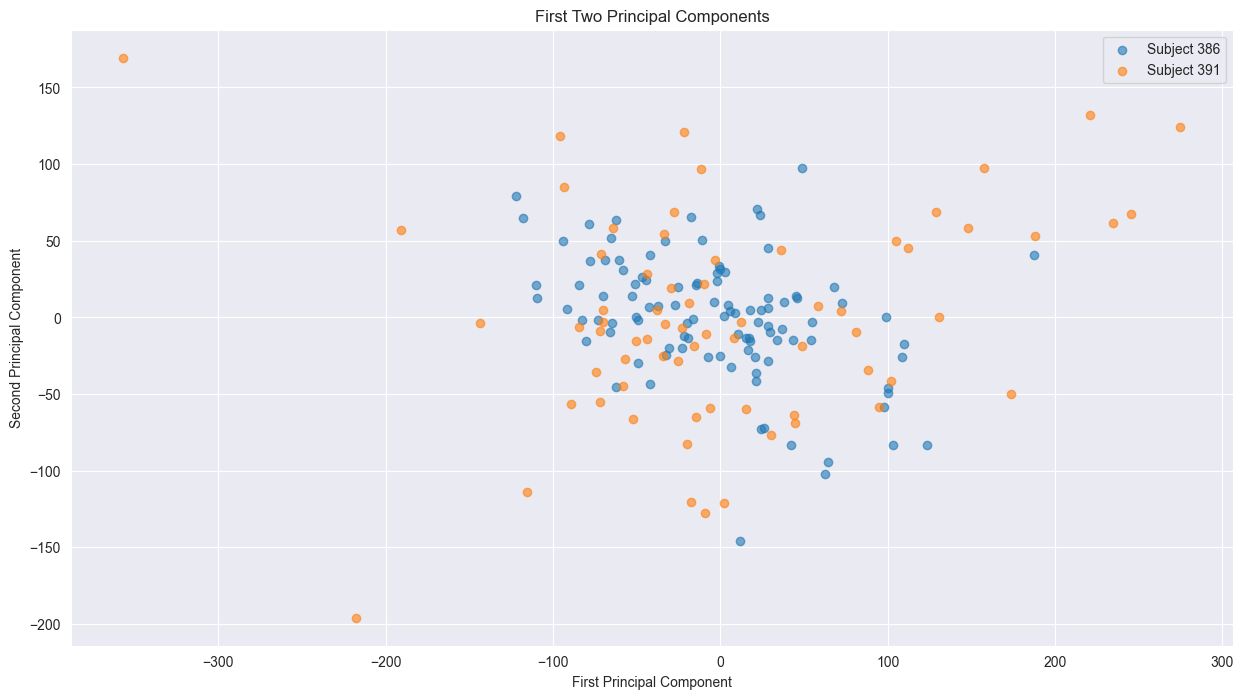


Explained variance ratio for each component:
PC1: 0.5249
PC2: 0.2223
PC3: 0.1614
PC4: 0.0571
PC5: 0.0211
PC6: 0.0128
PC7: 0.0002
PC8: 0.0001
PC9: 0.0000
PC10: 0.0000

Cumulative explained variance ratio:
[0.52491301 0.74717032 0.90855639 0.96569352 0.98680786 0.99959181
 0.9997476  0.99987461 0.99991956 0.99993361]


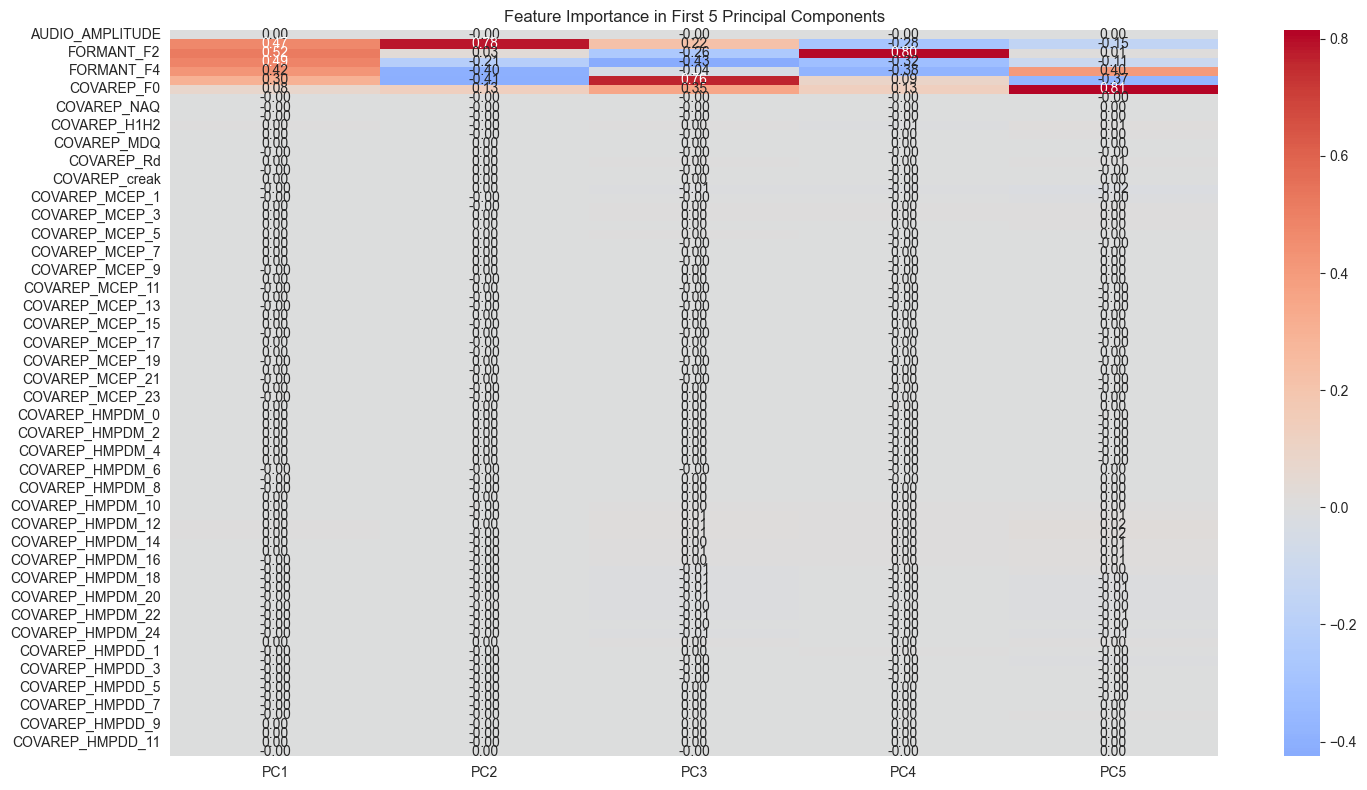

In [4]:
from sklearn.decomposition import PCA
from utils.pca_utils import save_pca_components


def perform_pca(df: pd.DataFrame, n_components: int = 10) -> Tuple[pd.DataFrame, pd.DataFrame, PCA]:
    #Perform PCA on the input data.
    # Select numerical features
    feature_data = df.select_dtypes(include=['float64', 'int64'])

    # Initialize and fit PCA
    pca = PCA(n_components=n_components)  # adjust n_components 
    feature_pca = pca.fit_transform(feature_data)
    
    # Determine the most important features for the first principal component
    abs_loadings = np.abs(pca.components_[0])
    sorted_indices = np.argsort(abs_loadings)[::-1]
    feature_names = [feature_data[i] for i in sorted_indices[:n_components]] # NOTE: feature_data might be the wrong thing and you might need another var here

    # Save PCA components
    save_pca_components(
        pca=pca,
        feature_names=feature_names,
        output_path='models/pca_audio.pkl'
    )
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        feature_pca,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.index
    )
    
    # Get feature importance
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.columns
    )

    return pca_df, feature_importance, pca


# Perform PCA
pca_df, feature_importance, pca = perform_pca(df_audio) # NOTE: nby default rhe PCA will cut it down to 10 features. you can change that by setting n_components

# Plot explained variance ratio
plt.figure(figsize=FIGURE_SIZE)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot first two principal components
plt.figure(figsize=FIGURE_SIZE)
for id in pca_df.index.get_level_values('ID').unique():
    mask = pca_df.index.get_level_values('ID') == id
    plt.scatter(pca_df[mask]['PC1'],
                pca_df[mask]['PC2'],
                alpha=0.6,
                label=f'Subject {id}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratios
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i + 1}: {ratio:.4f}")

# Print Cumulative explained variance ratio
print("\nCumulative explained variance ratio:")
print(np.cumsum(pca.explained_variance_ratio_))

# Plot heatmap of feature importance for first few components
plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(feature_importance.iloc[:, :5],
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Feature Importance in First 5 Principal Components')
plt.tight_layout()
plt.show()

## Data Splitting

In [5]:
def prepare_data_splits(df_audio: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #Prepare data splits for training, validation, and testing.
    # Merge audio features with depression labels
    df = pd.merge(df_audio, df_result, on='ID')  

    # Prepare features and target
    X = df.drop(['PHQ_Binary'], axis=1)
    y = df['PHQ_Binary']

    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)
    train_indices = []
    test_indices = []

    # Get split indices while preserving temporal order
    for train_idx, test_idx in tscv.split(X):
        train_indices.append(train_idx)
        test_indices.append(test_idx)

    # Use the last fold for final train/test split
    X_train = X.iloc[train_indices[-1]]
    X_test = X.iloc[test_indices[-1]]
    y_train = y.iloc[train_indices[-1]]
    y_test = y.iloc[test_indices[-1]]

    # Further split training data into train and validation
    train_size = int(0.75 * len(X_train))
    X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
    y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)



## Model Training

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = AudioRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )

        # Initialize trainer
        trainer = AudioRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE
        )

        # Train model
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params

    return best_params, results


# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID) # TODO: set num of epochs as well

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

Training: 100%|██████████| 4/4 [00:00<00:00, 174.66it/s, loss=0.7026]

Validation: 100%|██████████| 2/2 [00:00<00:00, 344.53it/s, loss=0.6856]


Epoch 1/50
Train Loss: 0.7091, Val Loss: 0.6867, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 236.63it/s, loss=0.6885]

Validation: 100%|██████████| 2/2 [00:00<00:00, 401.37it/s, loss=0.6973]


Epoch 2/50
Train Loss: 0.6957, Val Loss: 0.6987, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 233.92it/s, loss=0.6754]

Validation: 100%|██████████| 2/2 [00:00<00:00, 386.79it/s, loss=0.7089]


Epoch 3/50
Train Loss: 0.6820, Val Loss: 0.7107, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 231.58it/s, loss=0.6646]

Validation: 100%|██████████| 2/2 [00:00<00:00, 345.84it/s, loss=0.7206]


Epoch 4/50
Train Loss: 0.6701, Val Loss: 0.7229, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 256.14it/s, loss=0.6444]

Validation: 100%|██████████| 2/2 [00:00<00:00, 413.29it/s, loss=0.7329]


Epoch 5/50
Train Loss: 0.6557, Val Loss: 0.7360, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 219.90it/s, loss=0.6441]

Validation: 100%|██████████| 2/2 [00:00<00:00, 433.77it/s, loss=0.7341]


Epoch 6/50
Train Loss: 0.6476, Val Loss: 0.7373, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 227.88it/s, loss=0.6381]

Validation: 100%|██████████| 2/2 [00:00<00:00, 326.05it/s, loss=0.7355]


Epoch 7/50
Train Loss: 0.6438, Val Loss: 0.7387, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 253.33it/s, loss=0.6445]

  6%|▋         | 1/16 [00:00<00:03,  3.82it/s]

Epoch 8/50
Train Loss: 0.6436, Val Loss: 0.7401, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 195.86it/s, loss=0.6113]

Validation: 100%|██████████| 2/2 [00:00<00:00, 417.53it/s, loss=0.7899]


Epoch 1/50
Train Loss: 0.6209, Val Loss: 0.7902, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 212.32it/s, loss=0.5912]

Validation: 100%|██████████| 2/2 [00:00<00:00, 332.10it/s, loss=0.8107]


Epoch 2/50
Train Loss: 0.6031, Val Loss: 0.8111, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 232.72it/s, loss=0.5722]

Validation: 100%|██████████| 2/2 [00:00<00:00, 411.63it/s, loss=0.8337]


Epoch 3/50
Train Loss: 0.5886, Val Loss: 0.8340, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 204.34it/s, loss=0.5518]

Validation: 100%|██████████| 2/2 [00:00<00:00, 377.78it/s, loss=0.8590]


Epoch 4/50
Train Loss: 0.5711, Val Loss: 0.8593, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 205.61it/s, loss=0.5324]

Validation: 100%|██████████| 2/2 [00:00<00:00, 434.51it/s, loss=0.8873]


Epoch 5/50
Train Loss: 0.5528, Val Loss: 0.8877, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 223.44it/s, loss=0.5601]

Validation: 100%|██████████| 2/2 [00:00<00:00, 391.17it/s, loss=0.8903]


Epoch 6/50
Train Loss: 0.5458, Val Loss: 0.8907, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 224.73it/s, loss=0.5250]

Validation: 100%|██████████| 2/2 [00:00<00:00, 417.18it/s, loss=0.8935]


Epoch 7/50
Train Loss: 0.5375, Val Loss: 0.8938, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 227.57it/s, loss=0.5219]

 12%|█▎        | 2/16 [00:00<00:03,  3.71it/s]

Epoch 8/50
Train Loss: 0.5341, Val Loss: 0.8970, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 250.75it/s, loss=0.6999]

Validation: 100%|██████████| 2/2 [00:00<00:00, 439.29it/s, loss=0.6836]


Epoch 1/50
Train Loss: 0.7021, Val Loss: 0.6805, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 249.28it/s, loss=0.7011]

Validation: 100%|██████████| 2/2 [00:00<00:00, 384.18it/s, loss=0.6849]


Epoch 2/50
Train Loss: 0.7016, Val Loss: 0.6819, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 238.71it/s, loss=0.6953]

Validation: 100%|██████████| 2/2 [00:00<00:00, 419.56it/s, loss=0.6862]


Epoch 3/50
Train Loss: 0.7000, Val Loss: 0.6833, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 261.37it/s, loss=0.6976]

Validation: 100%|██████████| 2/2 [00:00<00:00, 447.15it/s, loss=0.6875]


Epoch 4/50
Train Loss: 0.6988, Val Loss: 0.6846, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 244.78it/s, loss=0.6939]

Validation: 100%|██████████| 2/2 [00:00<00:00, 393.24it/s, loss=0.6888]


Epoch 5/50
Train Loss: 0.6979, Val Loss: 0.6860, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 261.60it/s, loss=0.6968]

Validation: 100%|██████████| 2/2 [00:00<00:00, 419.56it/s, loss=0.6889]


Epoch 6/50
Train Loss: 0.6958, Val Loss: 0.6861, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 219.24it/s, loss=0.6912]

Validation: 100%|██████████| 2/2 [00:00<00:00, 391.94it/s, loss=0.6890]


Epoch 7/50
Train Loss: 0.6956, Val Loss: 0.6863, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 247.89it/s, loss=0.6880]

 19%|█▉        | 3/16 [00:00<00:03,  3.91it/s]

Epoch 8/50
Train Loss: 0.6937, Val Loss: 0.6864, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 224.42it/s, loss=0.6619]

Validation: 100%|██████████| 2/2 [00:00<00:00, 297.80it/s, loss=0.7204]


Epoch 1/50
Train Loss: 0.6685, Val Loss: 0.7207, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 212.93it/s, loss=0.6593]

Validation: 100%|██████████| 2/2 [00:00<00:00, 363.24it/s, loss=0.7233]


Epoch 2/50
Train Loss: 0.6642, Val Loss: 0.7236, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 239.92it/s, loss=0.6661]

Validation: 100%|██████████| 2/2 [00:00<00:00, 379.44it/s, loss=0.7262]


Epoch 3/50
Train Loss: 0.6650, Val Loss: 0.7265, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 238.28it/s, loss=0.6651]

Validation: 100%|██████████| 2/2 [00:00<00:00, 442.48it/s, loss=0.7291]


Epoch 4/50
Train Loss: 0.6619, Val Loss: 0.7293, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 224.96it/s, loss=0.6691]

Validation: 100%|██████████| 2/2 [00:00<00:00, 401.85it/s, loss=0.7321]


Epoch 5/50
Train Loss: 0.6616, Val Loss: 0.7323, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 228.34it/s, loss=0.6561]

Validation: 100%|██████████| 2/2 [00:00<00:00, 442.39it/s, loss=0.7323]


Epoch 6/50
Train Loss: 0.6572, Val Loss: 0.7326, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 222.69it/s, loss=0.6615]

Validation: 100%|██████████| 2/2 [00:00<00:00, 425.45it/s, loss=0.7326]


Epoch 7/50
Train Loss: 0.6590, Val Loss: 0.7329, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 226.96it/s, loss=0.6543]

 25%|██▌       | 4/16 [00:01<00:03,  3.82it/s]

Epoch 8/50
Train Loss: 0.6568, Val Loss: 0.7332, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 234.74it/s, loss=0.6690]

Validation: 100%|██████████| 2/2 [00:00<00:00, 364.29it/s, loss=0.7359]


Epoch 1/50
Train Loss: 0.6762, Val Loss: 0.7358, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 242.16it/s, loss=0.6375]

Validation: 100%|██████████| 2/2 [00:00<00:00, 370.23it/s, loss=0.7621]


Epoch 2/50
Train Loss: 0.6492, Val Loss: 0.7623, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 239.55it/s, loss=0.6118]

Validation: 100%|██████████| 2/2 [00:00<00:00, 342.76it/s, loss=0.7907]


Epoch 3/50
Train Loss: 0.6224, Val Loss: 0.7918, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 248.17it/s, loss=0.5920]

Validation: 100%|██████████| 2/2 [00:00<00:00, 342.11it/s, loss=0.8244]


Epoch 4/50
Train Loss: 0.5968, Val Loss: 0.8265, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 224.59it/s, loss=0.5354]

Validation: 100%|██████████| 2/2 [00:00<00:00, 397.06it/s, loss=0.8629]


Epoch 5/50
Train Loss: 0.5635, Val Loss: 0.8666, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 230.91it/s, loss=0.5322]

Validation: 100%|██████████| 2/2 [00:00<00:00, 378.29it/s, loss=0.8673]


Epoch 6/50
Train Loss: 0.5387, Val Loss: 0.8712, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 207.91it/s, loss=0.5164]

Validation: 100%|██████████| 2/2 [00:00<00:00, 391.63it/s, loss=0.8718]


Epoch 7/50
Train Loss: 0.5379, Val Loss: 0.8758, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 208.68it/s, loss=0.5323]

 31%|███▏      | 5/16 [00:01<00:02,  3.83it/s]

Epoch 8/50
Train Loss: 0.5398, Val Loss: 0.8804, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 155.39it/s, loss=0.6641]

Validation: 100%|██████████| 2/2 [00:00<00:00, 400.58it/s, loss=0.7349]


Epoch 1/50
Train Loss: 0.6733, Val Loss: 0.7351, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 187.49it/s, loss=0.6482]

Validation: 100%|██████████| 2/2 [00:00<00:00, 360.15it/s, loss=0.7679]


Epoch 2/50
Train Loss: 0.6495, Val Loss: 0.7680, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 181.64it/s, loss=0.6155]

Validation: 100%|██████████| 2/2 [00:00<00:00, 330.42it/s, loss=0.8050]


Epoch 3/50
Train Loss: 0.6182, Val Loss: 0.8056, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 167.74it/s, loss=0.5863]

Validation: 100%|██████████| 2/2 [00:00<00:00, 342.81it/s, loss=0.8544]


Epoch 4/50
Train Loss: 0.5860, Val Loss: 0.8556, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 190.30it/s, loss=0.5496]

Validation: 100%|██████████| 2/2 [00:00<00:00, 361.75it/s, loss=0.9196]


Epoch 5/50
Train Loss: 0.5489, Val Loss: 0.9220, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 189.38it/s, loss=0.5262]

Validation: 100%|██████████| 2/2 [00:00<00:00, 327.81it/s, loss=0.9276]


Epoch 6/50
Train Loss: 0.5147, Val Loss: 0.9301, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 200.41it/s, loss=0.5157]

Validation: 100%|██████████| 2/2 [00:00<00:00, 446.73it/s, loss=0.9359]


Epoch 7/50
Train Loss: 0.5076, Val Loss: 0.9386, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 177.84it/s, loss=0.4828]

 38%|███▊      | 6/16 [00:01<00:02,  3.60it/s]

Epoch 8/50
Train Loss: 0.4993, Val Loss: 0.9477, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 229.90it/s, loss=0.6424]

Validation: 100%|██████████| 2/2 [00:00<00:00, 377.20it/s, loss=0.7611]


Epoch 1/50
Train Loss: 0.6368, Val Loss: 0.7608, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 241.52it/s, loss=0.6222]

Validation: 100%|██████████| 2/2 [00:00<00:00, 394.87it/s, loss=0.7638]


Epoch 2/50
Train Loss: 0.6315, Val Loss: 0.7636, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 239.01it/s, loss=0.6357]

Validation: 100%|██████████| 2/2 [00:00<00:00, 436.00it/s, loss=0.7665]


Epoch 3/50
Train Loss: 0.6316, Val Loss: 0.7665, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 210.48it/s, loss=0.6225]

Validation: 100%|██████████| 2/2 [00:00<00:00, 397.13it/s, loss=0.7693]


Epoch 4/50
Train Loss: 0.6278, Val Loss: 0.7694, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 209.00it/s, loss=0.6201]

Validation: 100%|██████████| 2/2 [00:00<00:00, 366.09it/s, loss=0.7721]


Epoch 5/50
Train Loss: 0.6253, Val Loss: 0.7723, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 237.25it/s, loss=0.6175]

Validation: 100%|██████████| 2/2 [00:00<00:00, 415.01it/s, loss=0.7723]


Epoch 6/50
Train Loss: 0.6234, Val Loss: 0.7726, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 236.50it/s, loss=0.6312]

Validation: 100%|██████████| 2/2 [00:00<00:00, 483.33it/s, loss=0.7726]


Epoch 7/50
Train Loss: 0.6262, Val Loss: 0.7729, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 219.88it/s, loss=0.6232]

 44%|████▍     | 7/16 [00:01<00:02,  3.69it/s]

Epoch 8/50
Train Loss: 0.6243, Val Loss: 0.7732, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 191.82it/s, loss=0.7950]

Validation: 100%|██████████| 2/2 [00:00<00:00, 329.43it/s, loss=0.5975]


Epoch 1/50
Train Loss: 0.7934, Val Loss: 0.5974, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 191.88it/s, loss=0.7605]

Validation: 100%|██████████| 2/2 [00:00<00:00, 347.70it/s, loss=0.6001]


Epoch 2/50
Train Loss: 0.7866, Val Loss: 0.6000, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 173.06it/s, loss=0.7618]

Validation: 100%|██████████| 2/2 [00:00<00:00, 359.32it/s, loss=0.6025]


Epoch 3/50
Train Loss: 0.7845, Val Loss: 0.6025, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 193.16it/s, loss=0.7877]

Validation: 100%|██████████| 2/2 [00:00<00:00, 355.68it/s, loss=0.6049]


Epoch 4/50
Train Loss: 0.7847, Val Loss: 0.6050, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 178.24it/s, loss=0.7736]

Validation: 100%|██████████| 2/2 [00:00<00:00, 337.79it/s, loss=0.6074]


Epoch 5/50
Train Loss: 0.7807, Val Loss: 0.6074, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 200.84it/s, loss=0.7735]

Validation: 100%|██████████| 2/2 [00:00<00:00, 410.92it/s, loss=0.6076]


Epoch 6/50
Train Loss: 0.7791, Val Loss: 0.6077, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 197.60it/s, loss=0.7841]

Validation: 100%|██████████| 2/2 [00:00<00:00, 377.08it/s, loss=0.6079]


Epoch 7/50
Train Loss: 0.7808, Val Loss: 0.6079, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 183.07it/s, loss=0.7847]

 50%|█████     | 8/16 [00:02<00:02,  3.54it/s]

Epoch 8/50
Train Loss: 0.7801, Val Loss: 0.6081, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 257.27it/s, loss=0.6947]

Validation: 100%|██████████| 2/2 [00:00<00:00, 380.30it/s, loss=0.7105]


Epoch 1/50
Train Loss: 0.7006, Val Loss: 0.7089, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 250.33it/s, loss=0.6792]

Validation: 100%|██████████| 2/2 [00:00<00:00, 426.16it/s, loss=0.7278]


Epoch 2/50
Train Loss: 0.6867, Val Loss: 0.7275, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 251.78it/s, loss=0.6625]

Validation: 100%|██████████| 2/2 [00:00<00:00, 451.49it/s, loss=0.7461]


Epoch 3/50
Train Loss: 0.6693, Val Loss: 0.7468, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 261.47it/s, loss=0.6383]

Validation: 100%|██████████| 2/2 [00:00<00:00, 357.04it/s, loss=0.7642]


Epoch 4/50
Train Loss: 0.6509, Val Loss: 0.7659, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 231.46it/s, loss=0.6302]

Validation: 100%|██████████| 2/2 [00:00<00:00, 416.23it/s, loss=0.7834]


Epoch 5/50
Train Loss: 0.6345, Val Loss: 0.7860, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 232.89it/s, loss=0.6090]

Validation: 100%|██████████| 2/2 [00:00<00:00, 465.88it/s, loss=0.7855]


Epoch 6/50
Train Loss: 0.6195, Val Loss: 0.7881, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 217.90it/s, loss=0.6483]

Validation: 100%|██████████| 2/2 [00:00<00:00, 293.47it/s, loss=0.7876]


Epoch 7/50
Train Loss: 0.6258, Val Loss: 0.7903, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 239.23it/s, loss=0.6315]

 56%|█████▋    | 9/16 [00:02<00:01,  3.69it/s]

Epoch 8/50
Train Loss: 0.6226, Val Loss: 0.7925, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 210.16it/s, loss=0.6945]

Validation: 100%|██████████| 2/2 [00:00<00:00, 372.43it/s, loss=0.6922]


Epoch 1/50
Train Loss: 0.7061, Val Loss: 0.6915, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 230.22it/s, loss=0.6804]

Validation: 100%|██████████| 2/2 [00:00<00:00, 375.87it/s, loss=0.7186]


Epoch 2/50
Train Loss: 0.6844, Val Loss: 0.7175, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 223.14it/s, loss=0.6433]

Validation: 100%|██████████| 2/2 [00:00<00:00, 394.33it/s, loss=0.7464]


Epoch 3/50
Train Loss: 0.6608, Val Loss: 0.7451, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 230.14it/s, loss=0.6177]

Validation: 100%|██████████| 2/2 [00:00<00:00, 353.55it/s, loss=0.7774]


Epoch 4/50
Train Loss: 0.6347, Val Loss: 0.7759, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 222.00it/s, loss=0.6164]

Validation: 100%|██████████| 2/2 [00:00<00:00, 386.68it/s, loss=0.8120]


Epoch 5/50
Train Loss: 0.6130, Val Loss: 0.8101, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 224.17it/s, loss=0.5826]

Validation: 100%|██████████| 2/2 [00:00<00:00, 400.09it/s, loss=0.8156]


Epoch 6/50
Train Loss: 0.5908, Val Loss: 0.8137, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 240.91it/s, loss=0.6096]

Validation: 100%|██████████| 2/2 [00:00<00:00, 448.32it/s, loss=0.8193]


Epoch 7/50
Train Loss: 0.5977, Val Loss: 0.8174, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 232.53it/s, loss=0.6031]

 62%|██████▎   | 10/16 [00:02<00:01,  3.71it/s]

Epoch 8/50
Train Loss: 0.5909, Val Loss: 0.8212, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 256.46it/s, loss=0.7515]

Validation: 100%|██████████| 2/2 [00:00<00:00, 521.10it/s, loss=0.6483]


Epoch 1/50
Train Loss: 0.7492, Val Loss: 0.6446, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 256.85it/s, loss=0.7434]

Validation: 100%|██████████| 2/2 [00:00<00:00, 472.78it/s, loss=0.6502]


Epoch 2/50
Train Loss: 0.7424, Val Loss: 0.6466, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 249.94it/s, loss=0.7381]

Validation: 100%|██████████| 2/2 [00:00<00:00, 441.48it/s, loss=0.6522]


Epoch 3/50
Train Loss: 0.7372, Val Loss: 0.6485, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 249.36it/s, loss=0.7467]

Validation: 100%|██████████| 2/2 [00:00<00:00, 450.85it/s, loss=0.6541]


Epoch 4/50
Train Loss: 0.7381, Val Loss: 0.6504, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 234.29it/s, loss=0.7373]

Validation: 100%|██████████| 2/2 [00:00<00:00, 410.24it/s, loss=0.6561]


Epoch 5/50
Train Loss: 0.7324, Val Loss: 0.6524, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 259.25it/s, loss=0.7283]

Validation: 100%|██████████| 2/2 [00:00<00:00, 343.29it/s, loss=0.6563]


Epoch 6/50
Train Loss: 0.7311, Val Loss: 0.6526, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 267.68it/s, loss=0.7287]

Validation: 100%|██████████| 2/2 [00:00<00:00, 318.92it/s, loss=0.6565]


Epoch 7/50
Train Loss: 0.7332, Val Loss: 0.6528, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 228.12it/s, loss=0.7317]

 69%|██████▉   | 11/16 [00:02<00:01,  3.84it/s]

Epoch 8/50
Train Loss: 0.7290, Val Loss: 0.6530, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 246.23it/s, loss=0.7711]

Validation: 100%|██████████| 2/2 [00:00<00:00, 368.07it/s, loss=0.5959]


Epoch 1/50
Train Loss: 0.7908, Val Loss: 0.5959, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 211.98it/s, loss=0.7998]

Validation: 100%|██████████| 2/2 [00:00<00:00, 350.69it/s, loss=0.5974]


Epoch 2/50
Train Loss: 0.7946, Val Loss: 0.5975, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 215.48it/s, loss=0.7987]

Validation: 100%|██████████| 2/2 [00:00<00:00, 339.32it/s, loss=0.5989]


Epoch 3/50
Train Loss: 0.7920, Val Loss: 0.5990, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 207.17it/s, loss=0.7964]

Validation: 100%|██████████| 2/2 [00:00<00:00, 400.32it/s, loss=0.6005]


Epoch 4/50
Train Loss: 0.7924, Val Loss: 0.6006, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 193.53it/s, loss=0.7772]

Validation: 100%|██████████| 2/2 [00:00<00:00, 409.84it/s, loss=0.6021]


Epoch 5/50
Train Loss: 0.7865, Val Loss: 0.6022, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 210.55it/s, loss=0.7966]

Validation: 100%|██████████| 2/2 [00:00<00:00, 380.02it/s, loss=0.6023]


Epoch 6/50
Train Loss: 0.7885, Val Loss: 0.6023, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 203.83it/s, loss=0.7635]

Validation: 100%|██████████| 2/2 [00:00<00:00, 388.04it/s, loss=0.6024]


Epoch 7/50
Train Loss: 0.7830, Val Loss: 0.6025, LR: 0.000010



Training: 100%|██████████| 4/4 [00:00<00:00, 200.55it/s, loss=0.7719]

 75%|███████▌  | 12/16 [00:03<00:01,  3.72it/s]

Epoch 8/50
Train Loss: 0.7841, Val Loss: 0.6026, LR: 0.000010
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 208.96it/s, loss=0.6790]

Validation: 100%|██████████| 2/2 [00:00<00:00, 409.50it/s, loss=0.7146]


Epoch 1/50
Train Loss: 0.6934, Val Loss: 0.7125, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 227.26it/s, loss=0.6650]

Validation: 100%|██████████| 2/2 [00:00<00:00, 395.75it/s, loss=0.7422]


Epoch 2/50
Train Loss: 0.6710, Val Loss: 0.7407, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 222.93it/s, loss=0.6370]

Validation: 100%|██████████| 2/2 [00:00<00:00, 425.36it/s, loss=0.7724]


Epoch 3/50
Train Loss: 0.6493, Val Loss: 0.7717, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 220.85it/s, loss=0.6069]

Validation: 100%|██████████| 2/2 [00:00<00:00, 353.62it/s, loss=0.8054]


Epoch 4/50
Train Loss: 0.6230, Val Loss: 0.8051, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 222.84it/s, loss=0.5729]

Validation: 100%|██████████| 2/2 [00:00<00:00, 369.48it/s, loss=0.8442]


Epoch 5/50
Train Loss: 0.5968, Val Loss: 0.8434, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 231.11it/s, loss=0.5885]

Validation: 100%|██████████| 2/2 [00:00<00:00, 469.16it/s, loss=0.8486]


Epoch 6/50
Train Loss: 0.5844, Val Loss: 0.8477, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 200.40it/s, loss=0.5692]

Validation: 100%|██████████| 2/2 [00:00<00:00, 371.06it/s, loss=0.8531]


Epoch 7/50
Train Loss: 0.5789, Val Loss: 0.8521, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 224.46it/s, loss=0.5588]

 81%|████████▏ | 13/16 [00:03<00:00,  3.73it/s]

Epoch 8/50
Train Loss: 0.5722, Val Loss: 0.8568, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 170.75it/s, loss=0.6798]

Validation: 100%|██████████| 2/2 [00:00<00:00, 388.34it/s, loss=0.7244]


Epoch 1/50
Train Loss: 0.6860, Val Loss: 0.7251, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 183.82it/s, loss=0.6407]

Validation: 100%|██████████| 2/2 [00:00<00:00, 372.58it/s, loss=0.7594]


Epoch 2/50
Train Loss: 0.6504, Val Loss: 0.7606, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 168.90it/s, loss=0.6318]

Validation: 100%|██████████| 2/2 [00:00<00:00, 352.18it/s, loss=0.7999]


Epoch 3/50
Train Loss: 0.6263, Val Loss: 0.8019, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 179.25it/s, loss=0.5580]

Validation: 100%|██████████| 2/2 [00:00<00:00, 381.89it/s, loss=0.8470]


Epoch 4/50
Train Loss: 0.5852, Val Loss: 0.8511, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 186.89it/s, loss=0.5120]

Validation: 100%|██████████| 2/2 [00:00<00:00, 321.95it/s, loss=0.9099]


Epoch 5/50
Train Loss: 0.5437, Val Loss: 0.9169, LR: 0.001000



Training: 100%|██████████| 4/4 [00:00<00:00, 173.41it/s, loss=0.5355]

Validation: 100%|██████████| 2/2 [00:00<00:00, 375.87it/s, loss=0.9174]


Epoch 6/50
Train Loss: 0.5170, Val Loss: 0.9248, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 186.32it/s, loss=0.4984]

Validation: 100%|██████████| 2/2 [00:00<00:00, 345.01it/s, loss=0.9252]


Epoch 7/50
Train Loss: 0.5147, Val Loss: 0.9330, LR: 0.000100



Training: 100%|██████████| 4/4 [00:00<00:00, 186.58it/s, loss=0.5448]

 88%|████████▊ | 14/16 [00:03<00:00,  3.54it/s]

Epoch 8/50
Train Loss: 0.5081, Val Loss: 0.9418, LR: 0.000100
Early stopping triggered at epoch 8



Training: 100%|██████████| 4/4 [00:00<00:00, 220.35it/s, loss=0.7318]

Validation: 100%|██████████| 2/2 [00:00<00:00, 383.13it/s, loss=0.6593]


Epoch 1/50
Train Loss: 0.7282, Val Loss: 0.6578, LR: 0.000100



 88%|████████▊ | 14/16 [00:03<00:00,  3.64it/s]


KeyboardInterrupt: 

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        28
           1       0.00      0.00      0.00         0

    accuracy                           0.50        28
   macro avg       0.50      0.25      0.33        28
weighted avg       1.00      0.50      0.67        28


/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being

<Figure size 1500x800 with 0 Axes>

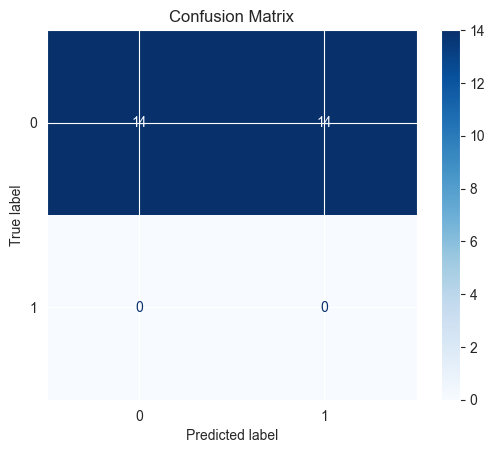

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    #Evaluate the model on the test set.
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Initialize best model
best_model = AudioRNN(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(DEVICE)

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [12]:
from training.trainer import save_model

# Save the model and scaler
save_model(best_model, scaler, "audio_model.pth")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
